## Show data patterns and cleaning

In [107]:
import pandas as pd

df = pd.read_csv("./dataset_raw.csv").drop(labels=["id"], axis=1)
print(f"Shape: {df.shape}")
df.head()

Shape: (27901, 17)


,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [108]:
df.info()
print(f"Duplicates: {sum(df.duplicated())}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  object 
 3   Profession                             27901 non-null  object 
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  object 
 10  Dietary Habits                         27901 non-null  object 
 11  De

"Finincial stress" has some null values.

In [109]:
df_notna = df.dropna()
print(f"Dropped {df.shape[0] - df_notna.shape[0]} rows with nulls")

Dropped 3 rows with nulls


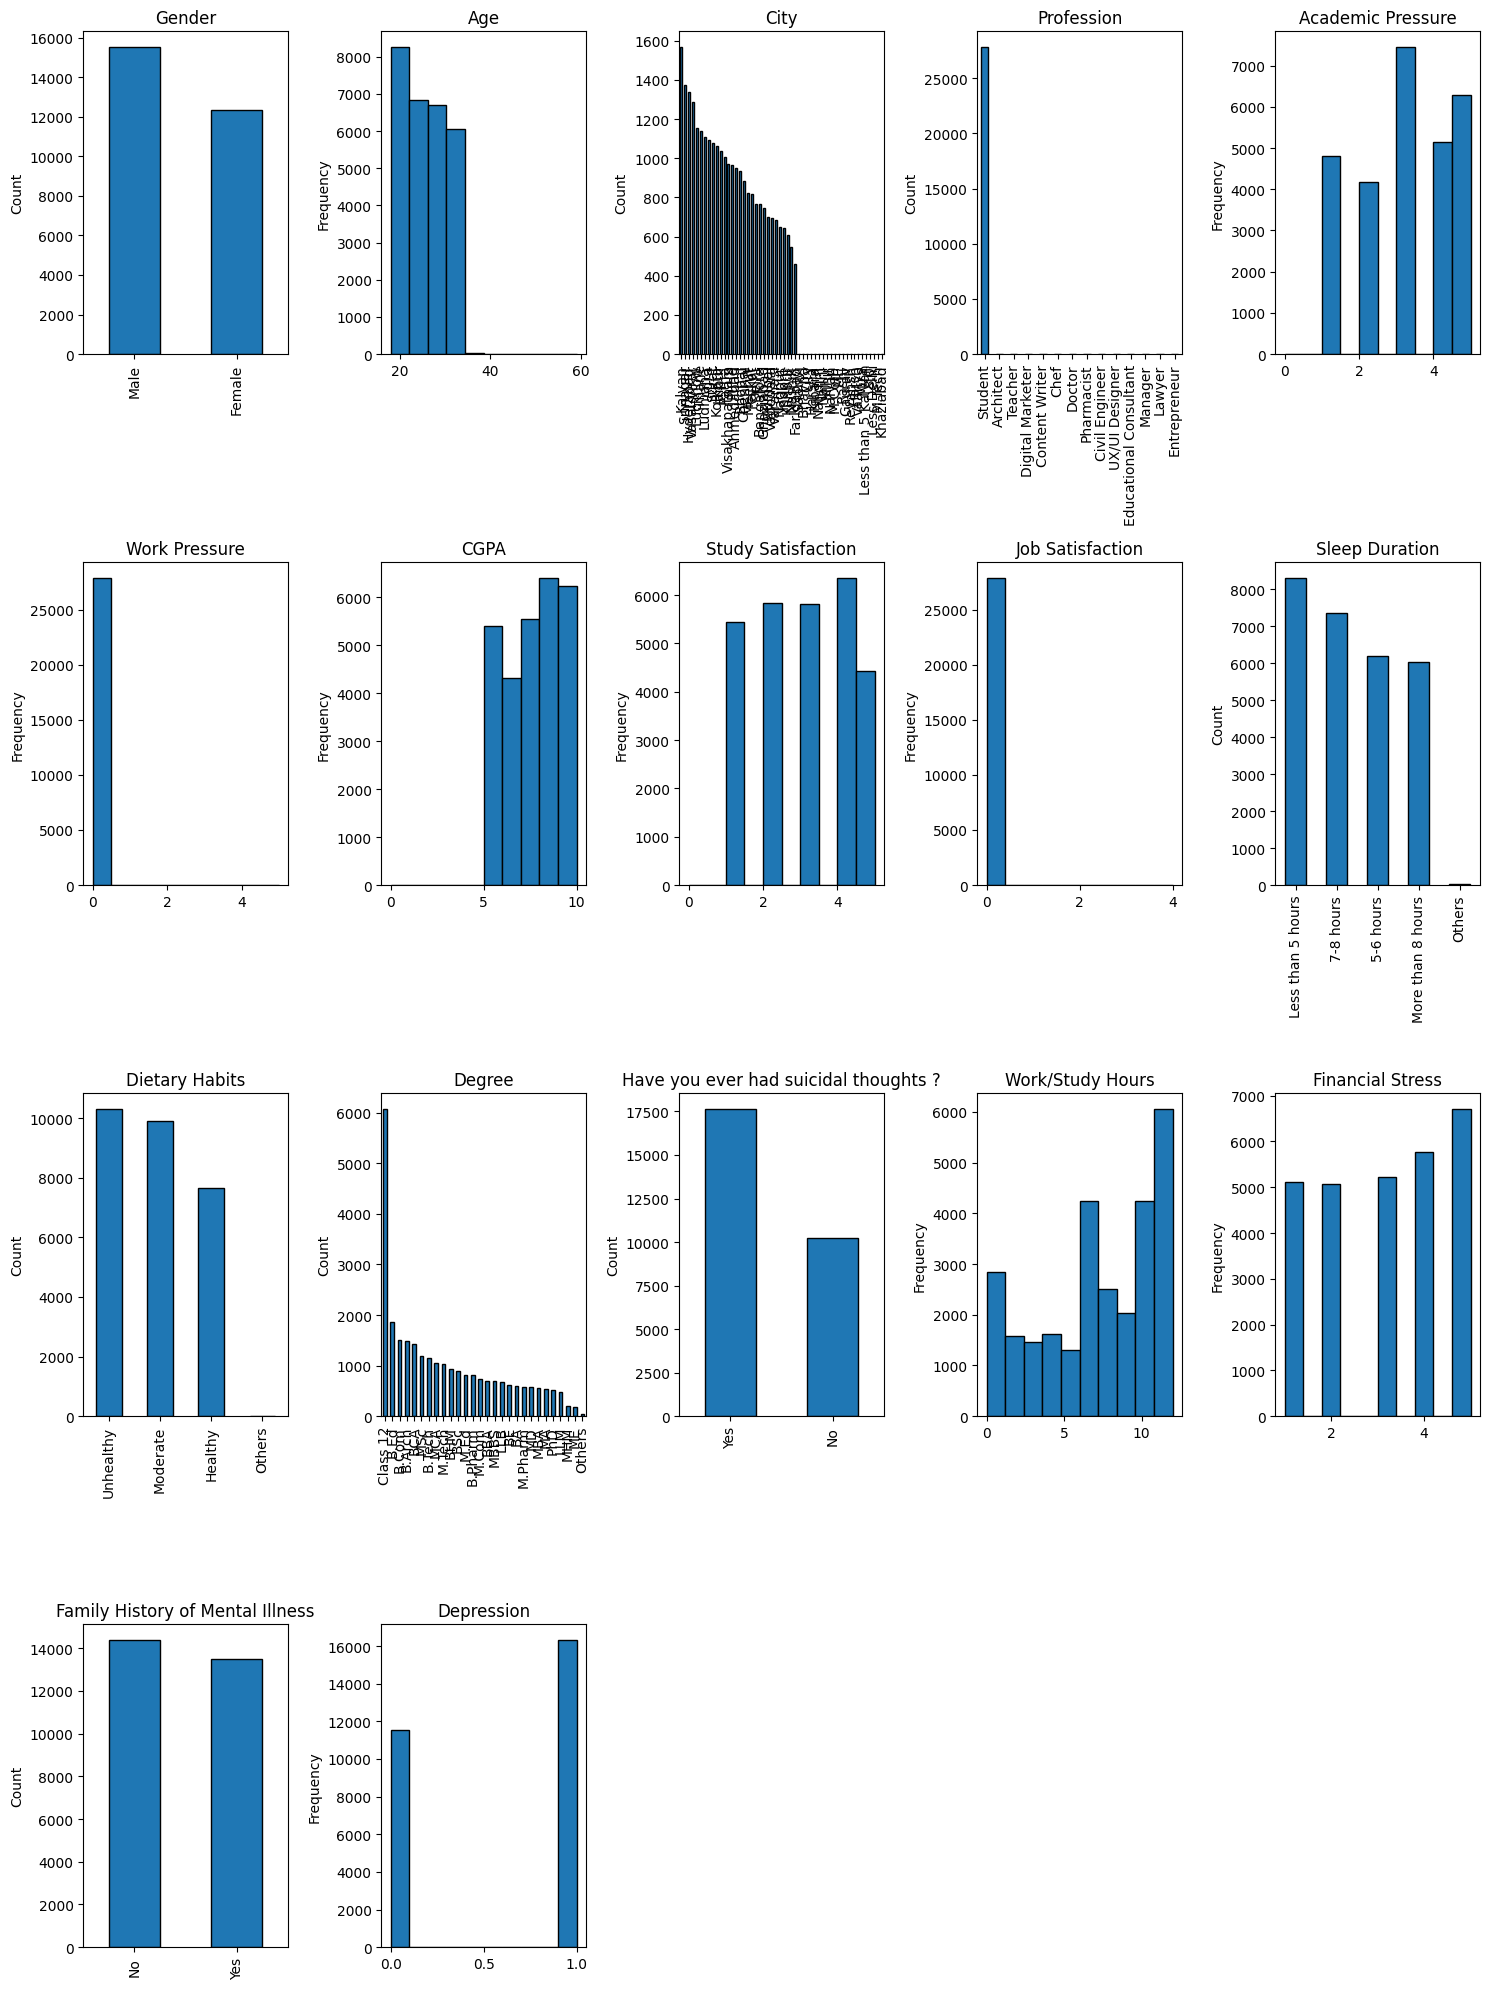

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of rows and columns for a "square-like" layout
n_cols = int(np.ceil(np.sqrt(len(df_notna.columns))))  # Number of columns
n_rows = int(np.ceil(len(df_notna.columns) / n_cols))  # Number of rows

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms or bar plots
for i, attr in enumerate(df_notna.columns):
    if np.issubdtype(df_notna[attr].dtype, np.number):  # Check if the attribute is numerical
        df_notna[attr].plot(kind='hist', ax=axes[i], title=attr, bins=10, edgecolor='black')
        axes[i].set_ylabel('Frequency')
    else:  # For categorical data
        df_notna[attr].value_counts().plot(kind='bar', ax=axes[i], title=attr, edgecolor='black')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel('')

# Hide unused subplots
for j in range(len(df_notna.columns), len(axes)):
    axes[j].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

As it can also seen [in online discussions](https://www.reddit.com/r/indiasocial/comments/1ax6qqg/what_is_the_reason_behind_majority_of_the/), indian students usually don't work as we can observe from "Work Pressure", "Profession" and "Job Satisfaction". 

Because of this we also have to remove the "working students" as they can change significantly the attribute "Work/Study Hours" and so then we'll can rename it in "Study Hours".

In [111]:
working_students = df_notna[df_notna["Profession"]!="Student"].index.to_list()
print(f"There are {len(working_students)} working students")

There are 31 working students


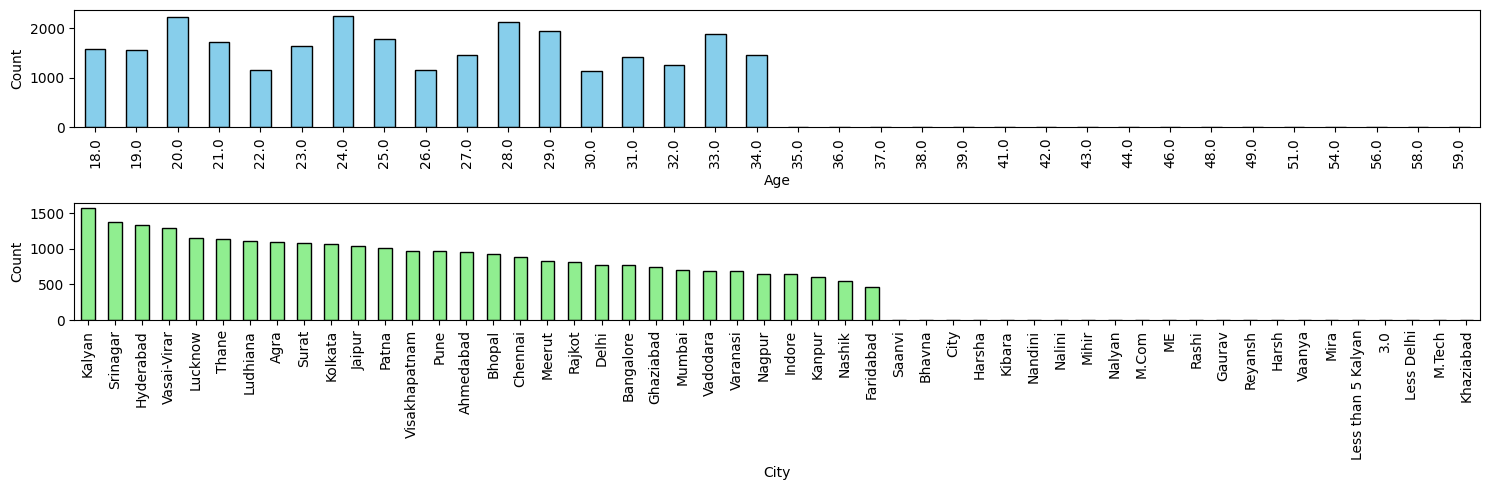

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))

df_notna['Age'].value_counts().sort_index().plot(kind='bar', ax=axes[0], edgecolor='black', color='skyblue')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

df_notna['City'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black', color='lightgreen')
axes[1].set_xlabel('City')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [113]:
threshold = 1 # % threshold over all the samples
city_counts = df_notna['City'].value_counts()
unpopular_cities = city_counts[city_counts < threshold/100*df_notna.shape[0]].index
students_in_unpopular_cities = df_notna[df_notna['City'].isin(unpopular_cities)].shape[0]
print(f"There are {students_in_unpopular_cities} students ({100*students_in_unpopular_cities/df_notna.shape[0]:.4f}%) in unpopular cities (which are {len(unpopular_cities)})")

over_34_students = df_notna[df_notna['Age'] > 34].shape[0]
print(f"There are {over_34_students} students over 34 y/o (which are {100*over_34_students/df_notna.shape[0]:.4f}%)")

There are 26 students (0.0932%) in unpopular cities (which are 22)
There are 49 students over 34 y/o (which are 0.1756%)


As unpopular cities have not been found, they will be removed from the dataset

Since we are working on Bayesian Networks and outliers are not that much a problem, so we'll keep the data of Age and City as they are by now.

In [114]:
df_cleaned = df_notna.drop(columns=["Profession", "Work Pressure", "Job Satisfaction"])
df_cleaned.drop(index=working_students, inplace=True)
df_cleaned.rename(columns={"Work/Study Hours" : "Study Hours"}, inplace=True)

# remove cities
df_cleaned=df_cleaned[(df_cleaned['City']!='3.0') & (df_cleaned['City']!='Bhavna') &
                        (df_cleaned['City']!='City') & (df_cleaned['City']!='Gaurav') &
                        (df_cleaned['City']!='Harsh') & (df_cleaned['City']!='Harsha') &
                        (df_cleaned['City']!='Khaziabad') & (df_cleaned['City']!='Kibara') &
                        (df_cleaned['City']!='Less Delhi') & (df_cleaned['City']!='Less than 5 Kalyan') &
                        (df_cleaned['City']!='M.Tech') & (df_cleaned['City']!='M.Com') &
                        (df_cleaned['City']!='ME') & (df_cleaned['City']!='Mihir') &
                        (df_cleaned['City']!='Mira') & (df_cleaned['City']!='Nalini	') &
                        (df_cleaned['City']!='Nalyan') & (df_cleaned['City']!='Nandini') &
                        (df_cleaned['City']!='Rashi') & (df_cleaned['City']!='Reyansh') &
                        (df_cleaned['City']!='Saanvi') & (df_cleaned['City']!='Vaanya')].reset_index(drop=True)


print(f"Shape: {df_cleaned.shape}")
df_cleaned.head()

Shape: (27842, 14)


,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33.0,Visakhapatnam,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Bangalore,2.0,5.90,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Srinagar,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Varanasi,3.0,5.59,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Jaipur,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


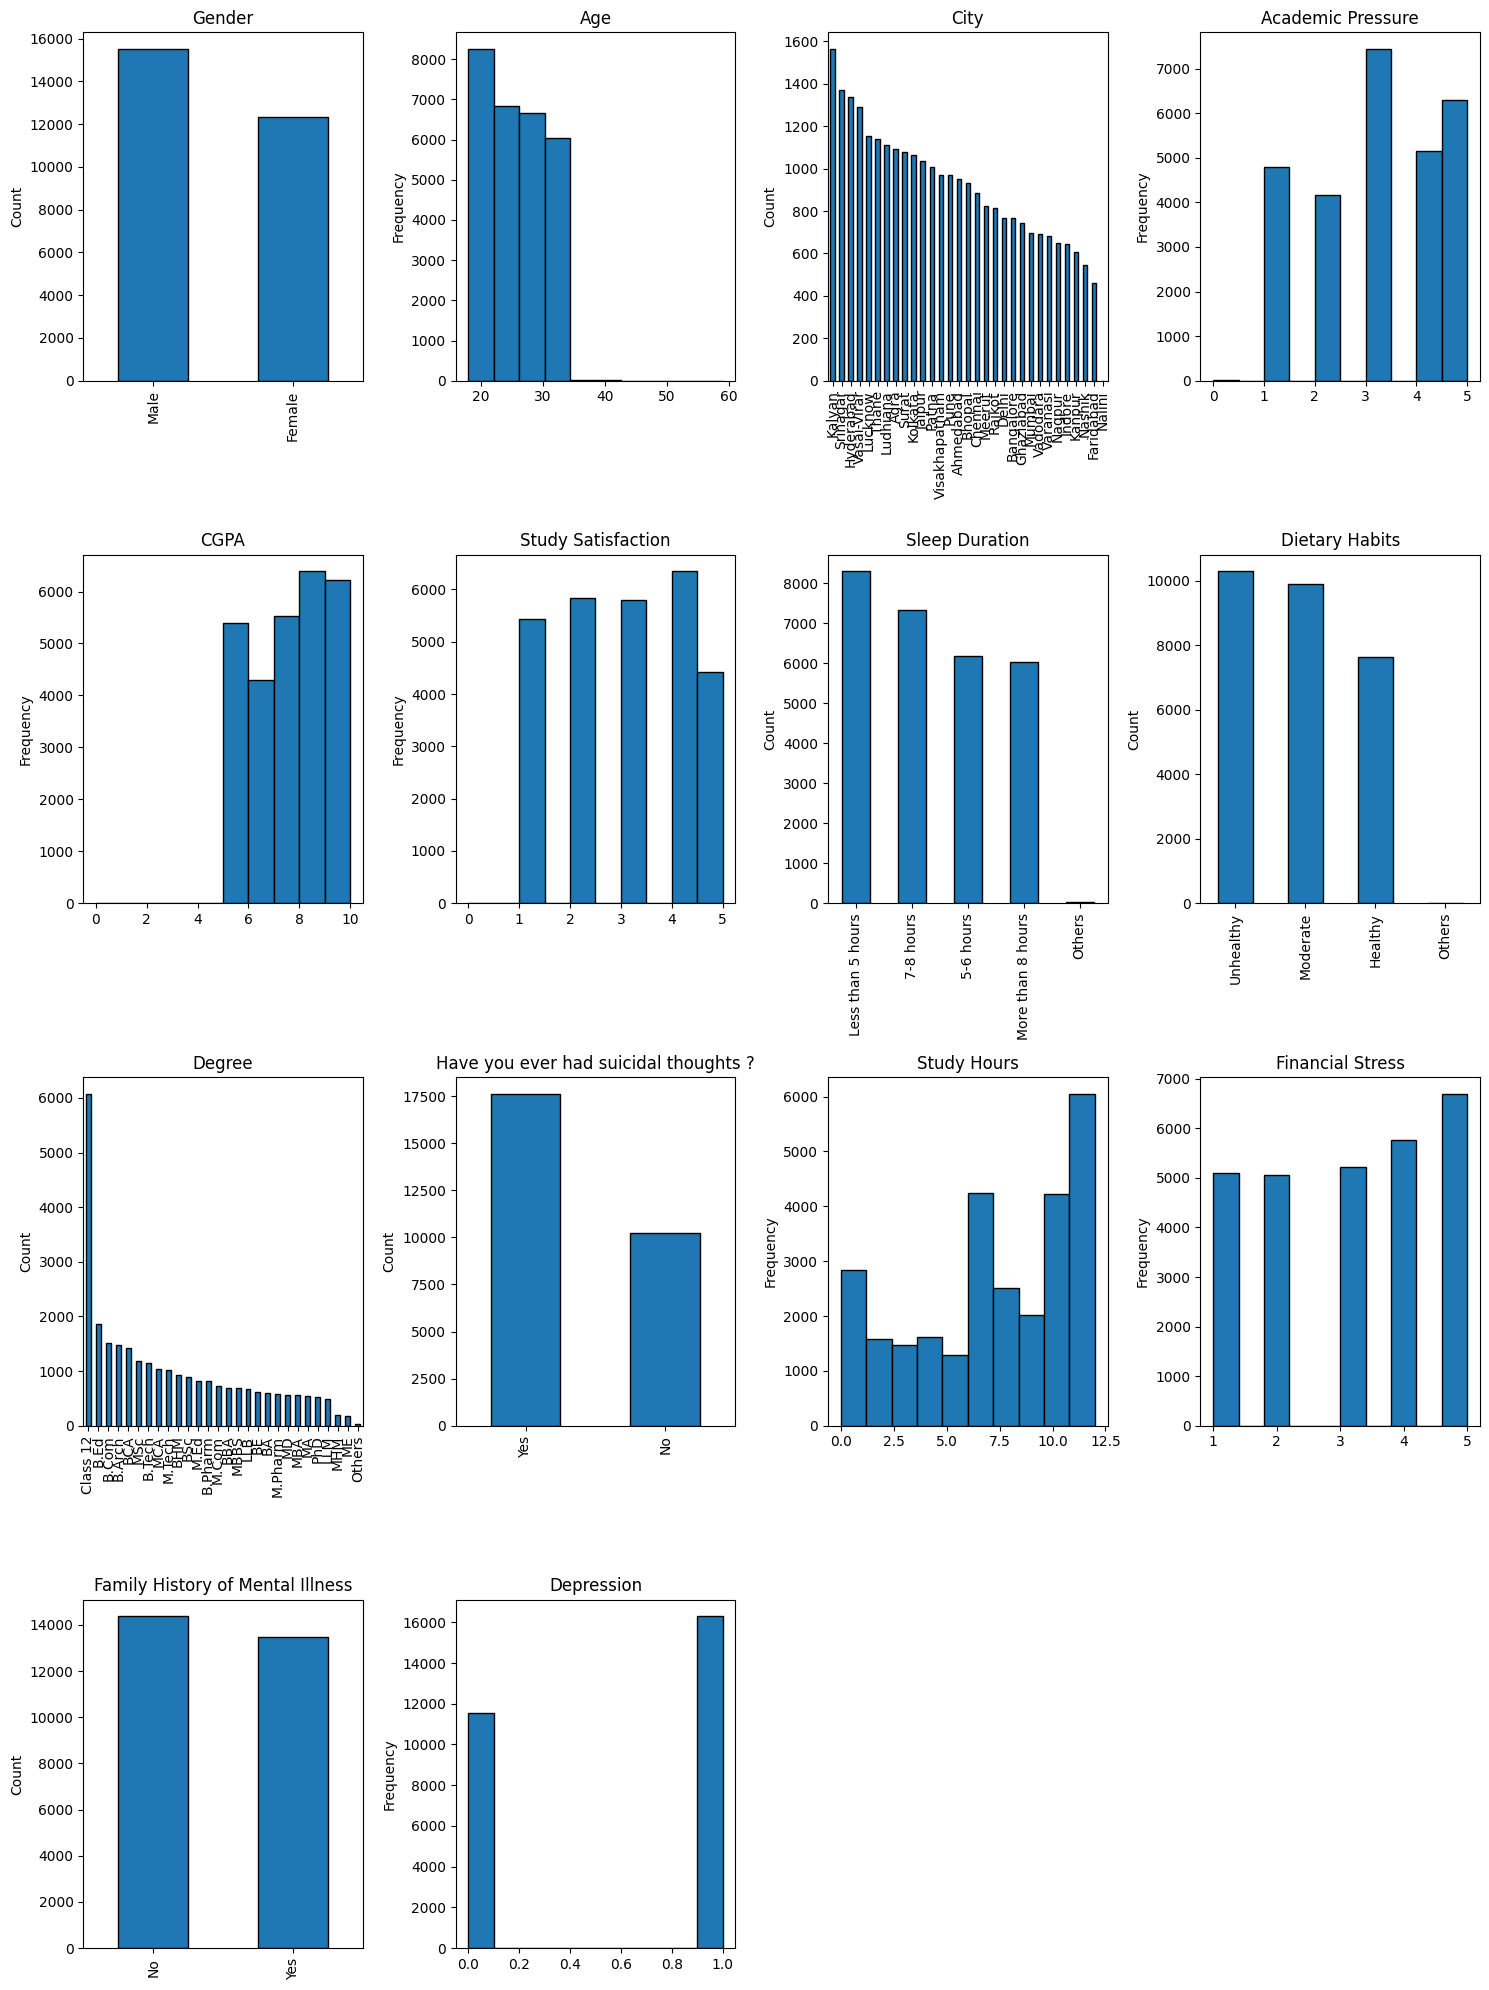

In [115]:
# Calculate the number of rows and columns for a "square-like" layout
n_cols = int(np.ceil(np.sqrt(len(df_cleaned.columns))))  # Number of columns
n_rows = int(np.ceil(len(df_cleaned.columns) / n_cols))  # Number of rows

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms or bar plots
for i, attr in enumerate(df_cleaned.columns):
    if np.issubdtype(df_cleaned[attr].dtype, np.number):  # Check if the attribute is numerical
        df_cleaned[attr].plot(kind='hist', ax=axes[i], title=attr, edgecolor='black')
        axes[i].set_ylabel('Frequency')
    else:  # For categorical data
        df_cleaned[attr].value_counts().plot(kind='bar', ax=axes[i], title=attr, edgecolor='black')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel('')

# Hide unused subplots
for j in range(len(df_cleaned.columns), len(axes)):
    axes[j].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Data preparantion 

Since we have to work with discrete numerical values in Bayesian Networks we have to make some bins and encode them.

1. [Gender](#gender)
2. [Age](#age)
3. [City](#city)
4. [Sleep Duration](#sleep-duration)
5. [Dietary Habits](#dietary-habits)
6. [Degree](#degree)
7. [Suicidial Thougths](#suicidial-thougths)
8. [Study Hours](#study-hours)
9. [Mental Ilness](#mental-illness)

In [116]:
df_final = pd.DataFrame()
label_mappings = {}

### Gender

In [117]:
from sklearn.preprocessing import LabelEncoder

label = "Gender"

encoder = LabelEncoder()
df_final[label] = encoder.fit_transform(df_cleaned[label])

label_mappings[label] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mappings[label]

{'Female': np.int64(0), 'Male': np.int64(1)}

### Age

We can divide the age in this way:

1. [18-22] are the "Young adults"
2. [23-27] are the "Early adults"
3. [28-32] are the "Mature young adults"
4. [33-40] are the "Middle-aged adults"
5. [41-60] are the "Older adults"

In [118]:
label = "Age"

min = df_cleaned[label].min()
max = df_cleaned[label].max()
print(f"The range is [{min},{max}]")

bins = [min-1, 22, 27, 32, 40, max]  
bin_label = list(range(len(bins) - 1))  

df_final[label] = pd.cut(
    df_cleaned[label], 
    bins=bins, 
    labels=bin_label
).reset_index(drop=True).astype(int)

label_mappings[label] = {f"{int(bins[l])+1}-{int(bins[l+1])}": l for l in bin_label}
label_mappings[label]

The range is [18.0,59.0]


{'18-22': 0, '23-27': 1, '28-32': 2, '33-40': 3, '41-59': 4}

### City

In [119]:
label = 'City'

display(np.unique(df[label]))

array(['3.0', 'Agra', 'Ahmedabad', 'Bangalore', 'Bhavna', 'Bhopal',
       'Chennai', 'City', 'Delhi', 'Faridabad', 'Gaurav', 'Ghaziabad',
       'Harsh', 'Harsha', 'Hyderabad', 'Indore', 'Jaipur', 'Kalyan',
       'Kanpur', 'Khaziabad', 'Kibara', 'Kolkata', 'Less Delhi',
       'Less than 5 Kalyan', 'Lucknow', 'Ludhiana', 'M.Com', 'M.Tech',
       'ME', 'Meerut', 'Mihir', 'Mira', 'Mumbai', 'Nagpur', 'Nalini',
       'Nalyan', 'Nandini', 'Nashik', 'Patna', 'Pune', 'Rajkot', 'Rashi',
       'Reyansh', 'Saanvi', 'Srinagar', 'Surat', 'Thane', 'Vaanya',
       'Vadodara', 'Varanasi', 'Vasai-Virar', 'Visakhapatnam'],
      dtype=object)

Impossible to find: Gaurav, harsh, harsha, khaziabad, agra is 

In [120]:
pd.DataFrame({'Cities':np.unique(df['City'], return_counts=True)[0], 'Presence':np.unique(df['City'], return_counts=True)[1]})

,Cities,Presence
0,3.0,1
1,Agra,1094
2,Ahmedabad,951
3,Bangalore,767
4,Bhavna,2
5,Bhopal,934
6,Chennai,885
7,City,2
8,Delhi,768
9,Faridabad,461


In [121]:
# use regions
label='Regions'

# label create a new attribute with regions
label_city_regions={'Agra':'Central',
                    'Ahmedabad':'Western',
                    'Bangalore': 'Southern',
                    'Bhopal':'Central',
                    'Chennai':'Southern',
                    'Delhi':'Northern',
                    'Faridabad':'Northern',
                    'Ghaziabad':'Central',
                    'Hyderabad':'Southern',
                    'Indore':'Central',
                    'Jaipur':'Northern',
                    'Kalyan':'Western',
                    'Kanpur':'Central',
                    'Kolkata':'Eastern',
                    'Lucknow':'Central',
                    'Ludhiana':'Northern',
                    'Meerut':'Central',
                    'Mumbai':'Western',
                    'Nagpur':'Western',
                    'Nashik':'Western',
                    'Patna':'Eastern',
                    'Pune':'Western',
                    'Rajkot':'Western',
                    'Srinagar':'Northern',
                    'Surat':'Western',
                    'Thane':'Western',
                    'Vadodara':'Western',
                    'Varanasi':'Central',
                    'Vasai-Virar':'Western',
                    'Visakhapatnam':'Southern',
                    }

df_cleaned['Regions']=df_cleaned['City'].map(label_city_regions).reset_index(drop=True)

#np.unique(np.array(list(label_city_regions.values())))

label_mappings[label]={'Central':0,'Eastern':1, 'Northern':2, 'Southern':3, 'Western':4}
label_mappings[label]

{'Central': 0, 'Eastern': 1, 'Northern': 2, 'Southern': 3, 'Western': 4}

In [122]:
df_final[label]=df_cleaned[label].map(label_mappings[label]).reset_index(drop=True)

### CGPA (??)

We can divide the CGPA:

- Fail: 0.0 - 2.9
- Below Average: 3.0 - 4.9
- Average: 5.0 - 6.9
- Good: 7.0 - 8.9
- Excellent: 9.0 - 10.0

In [123]:
label = "CGPA"

min = df_cleaned[label].min()
max = df_cleaned[label].max()
print(f"The range is [{min},{max}]")

bins = [min-1, 2.9, 4.9, 6.9, 8.9, max]  
bin_label = list(range(len(bins) - 1))  

df_final[label] = pd.cut(
    df_cleaned[label], 
    bins=bins, 
    labels=bin_label
).reset_index(drop=True).astype(int)

label_mappings[label] = {f"{int(bins[l])+1}-{bins[l+1]}": l for l in bin_label}
label_mappings[label]

The range is [0.0,10.0]


{'0-2.9': 0, '3-4.9': 1, '5-6.9': 2, '7-8.9': 3, '9-10.0': 4}

### Sleep Duration

In [124]:
label = "Sleep Duration"

label_mappings[label] = {
    'Less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'More than 8 hours': 3,
    'Others': -1
}

df_final[label] = df_cleaned[label].map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'Less than 5 hours': 0,
 '5-6 hours': 1,
 '7-8 hours': 2,
 'More than 8 hours': 3,
 'Others': -1}

### Dietary Habits

In [125]:
label = "Dietary Habits"

label_mappings[label] = {
    'Unhealthy' : 0, 
    'Moderate' : 1, 
    'Healthy' : 2, 
    'Others' : -1
}

df_final[label] = df_cleaned[label].map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'Unhealthy': 0, 'Moderate': 1, 'Healthy': 2, 'Others': -1}

### Degree

In order to group the degrees, let's see how they are represented

In [126]:
df_cleaned["Degree"].unique()

array(['B.Pharm', 'BSc', 'BA', 'BCA', 'M.Tech', 'PhD', 'Class 12', 'B.Ed',
       'LLB', 'BE', 'M.Ed', 'MSc', 'BHM', 'M.Pharm', 'MCA', 'MA', 'B.Com',
       'MD', 'MBA', 'MBBS', 'M.Com', 'B.Arch', 'LLM', 'B.Tech', 'BBA',
       'ME', 'MHM', 'Others'], dtype=object)

In [127]:
# The encoding
def decode_degree(degree):
    degree_mapping = {
        "B.Pharm": "Bachelor of Pharmacy",
        "BSc": "Bachelor of Science",
        "BA": "Bachelor of Arts",
        "BCA": "Bachelor of Computer Applications",
        "M.Tech": "Master of Technology",
        "PhD": "Doctor of Philosophy",
        "Class 12": "High School Completion (12th Grade)",
        "B.Ed": "Bachelor of Education",
        "LLB": "Bachelor of Laws",
        "BE": "Bachelor of Engineering",
        "M.Ed": "Master of Education",
        "MSc": "Master of Science",
        "BHM": "Bachelor of Hotel Management",
        "M.Pharm": "Master of Pharmacy",
        "MCA": "Master of Computer Applications",
        "MA": "Master of Arts",
        "B.Com": "Bachelor of Commerce",
        "MD": "Doctor of Medicine",
        "MBA": "Master of Business Administration",
        "MBBS": "Bachelor of Medicine, Bachelor of Surgery",
        "M.Com": "Master of Commerce",
        "B.Arch": "Bachelor of Architecture",
        "LLM": "Master of Laws",
        "B.Tech": "Bachelor of Technology",
        "BBA": "Bachelor of Business Administration",
        "ME": "Master of Engineering",
        "MHM": "Master of Hotel Management",
        "Others": "Other Qualifications"
    }
    
    return degree_mapping.get(degree, "Unknown Degree")

In [128]:
# We could group them by area of study + Barchelor/Master
...

### Suicidial Thougths

In [129]:
label = "Have you ever had suicidal thoughts ?"

encoder = LabelEncoder()
df_final[label] = encoder.fit_transform(df_cleaned[label])

label_mappings[label] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mappings[label]

{'No': np.int64(0), 'Yes': np.int64(1)}

### Study Hours

In [130]:
label = "Study Hours"

min = df_cleaned[label].min()
max = df_cleaned[label].max()
print(f"The range is [{min},{max}]")

bins = [min-1, 2, 4, 6, 8, max]  
bin_label = list(range(len(bins) - 1))  

df_final[label] = pd.cut(
    df_cleaned[label], 
    bins=bins, 
    labels=bin_label
).reset_index(drop=True).astype(int)

label_mappings[label] = {f"{int(bins[l])+1}-{int(bins[l+1])}": l for l in bin_label}
label_mappings[label]

The range is [0.0,12.0]


{'0-2': 0, '3-4': 1, '5-6': 2, '7-8': 3, '9-12': 4}

### Mental Illness

In [131]:
label = "Family History of Mental Illness"

encoder = LabelEncoder()
df_final[label] = encoder.fit_transform(df_cleaned[label])

label_mappings[label] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mappings[label]

{'No': np.int64(0), 'Yes': np.int64(1)}

## Final result

In [132]:
df_final

,Gender,Age,Regions,CGPA,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Family History of Mental Illness
0,1,3,3.0,4,1,2,1,1,0
1,0,1,3.0,2,1,1,0,1,1
2,1,2,2.0,3,0,2,0,4,1
3,0,2,0.0,2,2,1,1,1,1
4,0,1,2.0,3,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
27837,0,1,4.0,2,1,0,1,3,1
27838,1,1,2.0,4,0,2,0,0,1
27839,1,2,2.0,2,1,0,0,4,0
27840,0,0,2.0,2,0,2,1,4,0


In [133]:
# df_final.to_csv("dataset_final.csv", index=False)